In [1]:
# import torch
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from read_yse_ztf_snana_dir import read_YSE_ZTF_snana_dir

%matplotlib inline
from read_yse_ztf_snana_dir import read_YSE_ZTF_snana_dir
from matplotlib.backends.backend_pdf import PdfPages
import warnings
warnings.filterwarnings("ignore")
from PPCA import applyppca
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from PPCA import applypca
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import glob
import sncosmo
import light_curve
from light_curve import VillarFit
import extinction
from extinction import fm07, apply, remove
import statistics as st

import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
# Reset index for real data
snid_list, meta_list, yse_ztf_fp_df_list = read_YSE_ZTF_snana_dir('../Photpipe/spec_yse_dr1/')
real_data = pd.DataFrame(pd.read_csv('../Real_Data.csv'))
real_data = real_data.reset_index(drop=True)
# print(real_data.head())
''' 
To Do;
Go through meta_list and yse_ztf_fp_df_list and transient_spec_class
'''
#Go through meta_list and yse_ztf_fp_df_list and transient_spec_class 
#Add a column in real_data called class and fill it with none
real_data['class'] = 'None'

class_labels = []
for i in range(len(meta_list)):
    class_labels.append(meta_list[i]['transient_spec_class'])

# Make a dataframe of the class labels and snid_list
df_real_truth_columns = ['snid', 'class']

df_real_truths = pd.DataFrame(columns=df_real_truth_columns)

df_real_truths['snid'] = snid_list

df_real_truths['class'] = class_labels

# Go through real data and if it matches in snid_list, add the class label to the real_data dataframe
real_data = pd.merge(real_data, df_real_truths, how='left', left_on='ObjectID', right_on='snid')
# real_data

# Replace class labels that are not 'SNIa', 'SNII', 'SNIb', 'SNIc' with 'None'
# valid_class_labels = ['SNIa', 'SNIbc', 'SNII']

# #Make it so that any label SNIb or SNIc is SNIbc
# real_data['class_y'] = real_data['class_y'].apply(lambda x: 'SNIbc' if x in ['SNIb', 'SNIc'] else x)

# real_data['class_y'] = real_data['class_y'].apply(lambda x: x if x in valid_class_labels else 'None')

# IF YOU WANT ONLY TWO CLASSES COMMENT OUT LINE 32-37 AND UNCOMMENT LINE 40-45
valid_class_labels = ['SNIa', 'SNII']

#Make it so that any label SNIb or SNIc is SNIbc
real_data['class_y'] = real_data['class_y'].apply(lambda x: 'SNII' if x in ['SNIb', 'SNIc'] else x)

real_data['class_y'] = real_data['class_y'].apply(lambda x: x if x in valid_class_labels else 'None')

# Drop rows with 'None' class labels
real_data = real_data[real_data['class_y'] != 'None']

#Store class_y as a list
class_labels = real_data['class_y'].tolist()
# Drop the redundant 'snid' column
# real_data['class_y'].isin(['SNIbc']).any()
real_data.drop('snid', axis=1, inplace=True)
real_data.drop('class_x', axis=1, inplace=True)
real_data.drop('class_y', axis=1, inplace=True)
real_data.drop('ObjectID', axis=1, inplace=True)

real_data

df_real_data = real_data
real_labels = class_labels

Reading YSE+ZTF SNANA-style data files from directory:  ../Photpipe/spec_yse_dr1/


# Load in Simulated Dataset and format it correctly

In [3]:
def read_snana_fits(dir_path):
    snid_list = []
    meta_list = []
    yse_ztf_fp_df_list = []
    meta = {}
    objid = ""
    if (dir_path == "../Retrain_RAPID/for_YSE/data/PALEO_YSE_MODEL43_CCSNe_V19_yselc_v2_52LCs"):
        objid = "yselc_v2"
    #THIS IS SOMETHING THAT WE WILL NEED TO CHANGE
    elif (dir_path == "../../YSE_DR1_SIMS_60k_SNR4_grizXY_SIMLIB_FLUXCALERR_COR_220427/PALEO_YSE_ZTF_MODEL01"): #WILL NEED TO UPDATE FOR LOCAL MACHINE
        objid = "SNIa" #Update if not SN Ia
        
    
    
    heads = sorted(glob.glob(os.path.join(dir_path, '*_HEAD.FITS.gz')))
    phots = sorted(glob.glob(os.path.join(dir_path, '*_PHOT.FITS.gz')))
    assert len(heads) != 0, 'no *_HEAD_FITS.gz are found'
    assert len(heads) == len(phots), 'there are different number of HEAD and PHOT files'
    
    for head, phot in zip(heads, phots): #lots of LCs per head, phot files, so do a few to start
        i = head.find('_HEAD.FITS.gz')
        assert head[:i] == phot[:i], f'HEAD and PHOT files name mismatch: {head}, {phot}'
        filename = head[:i].split('/')[-1].split('.')[0]
        head_title = head[88:92] 
        
        for LCnum, lc in enumerate(sncosmo.read_snana_fits(head, phot)): # remember: multiple SN in single HEAD/PHOT file
            #print(lc.meta)
            lc.meta['redshift'] = lc.meta['SIM_REDSHIFT_HOST']
            redshift = lc.meta['redshift']
            mwebv_data = lc.meta['MWEBV']
            salt_mB = lc.meta['SIM_SALT2mB']
            salt_x1 = lc.meta['SIM_SALT2x1']
            salt_c = lc.meta['SIM_SALT2c']
            checkSnid = lc.meta['SNID']
            checkSnid = checkSnid.decode('UTF-8')
        

            
            redshift = np.round(redshift, 2)
            
            
            ra = lc.meta['RA']
            dec = lc.meta['DEC']
            lc.keep_columns(['MJD', 'BAND', 'FLUXCAL', 'FLUXCALERR', 'PHOTFLAG'])
            totalResidual = 0
            fitNew = []
            # Astropy Table --> Pandas df
            df = lc.to_pandas()
            df = df.rename(columns={
                "BAND": "PASSBAND", 
                "FLUXCAL": "FLUX",
                "FLUXCALERR": "FLUXERR", 
                "PHOTFLAG": "PHOTFLAG"
            })
            
            df['PASSBAND']= df['PASSBAND'].str.decode("utf-8") # turn Bytes into str
            snr = []
            snr = df['FLUX']/df['FLUXERR'] 
            df['MAG'] = np.array(-2.5*np.log10(np.abs(df['FLUX'])))+27.5
            magerr = []
            magerr = 1.086/snr
            df['MAGERR'] = magerr
            #Made DF and have all the info
            meta['object_id'] = objid
            meta['RA'] = ra
            meta['DEC'] = dec
            meta['redshift'] = redshift
            meta['SNID'] = checkSnid
            meta['Head'] = head_title
            meta['MWEBV'] = mwebv_data
            meta['mB'] = salt_mB
            meta['x1'] = salt_x1
            meta['c'] = salt_c
            snid_list.append(objid)
            meta_copy = meta.copy()
            meta_list.append(meta_copy)
            yse_ztf_fp_df_list.append(df)
#             meta.clear()
            
    return snid_list, meta_list, yse_ztf_fp_df_list

In [7]:
# Reset index for real data
# snid_list, meta_list, yse_ztf_fp_df_list = read_snana_fits('../Photpipe/spec_yse_dr1/')
# sim_data = pd.DataFrame(pd.read_csv('../all_sims.csv'))
sim_data = pd.DataFrame(pd.read_csv('../all_sims.csv'))
sim_data = sim_data.reset_index(drop=True)
# print(sim_data.head())
''' 
To Do;
Go through meta_list and yse_ztf_fp_df_list and transient_spec_class
'''
#Go through meta_list and yse_ztf_fp_df_list and transient_spec_class 
#Add a column in real_data called class and fill it with none
# sim_data['class'] = 'None'

class_labels = []

'''
3 Cases
_4877922_SNIa,
PALE_3861766_SNIbc,
PALE_2583690_SNII
'''
#Drop rows that are not SNIa, SNIbc
sim_data = sim_data[sim_data['ObjectID'].str.contains("SNIa|SNIbc|SNII")] #|SNII

# Iterate through sim_data and look at ObjectID. If it contains 'SNIa', 'SNIb', 'SNIc', or 'SNII', add that to class_labels
for i in range(len(sim_data)):
    if 'SNIa' in sim_data['ObjectID'][i]:
        class_labels.append('SNIa')
    elif 'SNIb' in sim_data['ObjectID'][i] or 'SNIc' in sim_data['ObjectID'][i]:
        class_labels.append('SNII')
    elif 'SNII' in sim_data['ObjectID'][i]:
        class_labels.append('SNII')
    else:
        class_labels.append('None')


#We have class_labels now as type list
sim_data.drop('ObjectID', axis=1, inplace=True)

sim_data

df_sim_data = sim_data
sim_labels = class_labels

In [8]:
len(df_real_data), len(real_labels)

(247, 247)

In [9]:
len(df_sim_data), len(sim_labels)

(51154, 51154)

In [10]:
#How to check if any elements in sim_labels are SNII
'SNIbc' in sim_labels #CHECK TO SEE IF THIS IS WHAT YOU WANT THIS NEEDS TO MATCH BELOW

False

In [11]:
'SNIbc' in real_labels #CHECK TO SEE IF THIS IS WHAT YOU WANT THIS NEED TO MATCH ABOVE

False

In [ ]:
# # Sacha's Code
# snIa = pd.DataFrame(pd.read_csv('../SNIa_sims.csv'))
# snIbc = pd.DataFrame(pd.read_csv('../SNIbc_sims.csv'))
# snII = pd.DataFrame(pd.read_csv('../SNII_sims.csv'))

# train_data = pd.concat([snIa, snIbc, snII])

# # extracting the IDs that have sufficient information 
# train_ids = list(train_data['ObjectID'])

# columns = ['object_id', 'transient_spec_class']

# specs = []
# for dic in meta_list:
#     spec = dic['transient_spec_class']
#     specs.append(spec)

# p = dict(zip(snid_list, specs))
# ground_truth_dict_train = dict(zip(snid_list, specs))
# ground_truth_train = pd.DataFrame(zip(snid_list, specs), columns=columns)

# train_labels = ['SNIa']*len(snIa) + ['SNIbc']*len(snIbc) + ['SNII']*len(snII)

# train_truths = zip(train_ids, train_labels)
# df_train_truths = pd.DataFrame(train_truths, columns=['id', 'class'])

# # remove weird classes
# # df_real_truths = df_real_truths.drop('SNIa-CSM', axis=0)
# '''
# df_train_truths = df_train_truths[~df_train_truths['class'].isin(['SNIa-CSM', 'SNIIP', 'SNIIn', \
#             'SNIa-91T-like', 'SNIa-SC', 'SNIax[02cx-like]', 'SLSN-II', 'SNIIb', 'SLSN-I', 'SNIb/c', 'SNIc-BL'])]

# b = [x for x in range(df_train_truths.index[0], df_train_truths.index[-1] + 1)]
# a = set(df_train_truths.index)
# weird = list(df_train_truths.index ^ set(b))
# print(np.array(weird).dtype, train_data.index.dtype)
# '''

# # remove rows in real_data.csv that correspond to the removed weird classes
# #train_data_rem = real_data[~train_data.index.isin(weird)]
# train_data_rem = train_data

# # remove the object ID column from real_data
# df_train_data = train_data_rem.drop('ObjectID', axis=1)
# train_labels = df_train_truths['class']
# df_train_data = df_train_data.reset_index(drop=True)
# print(df_train_truths.shape, df_train_data.shape)


In [ ]:
# df_train_data
# df_sim_data

# # Check see if df_train_data is the same as df_sim_data
# # df_train_data.equals(df_sim_data)
# print(len(df_train_data), type(df_train_data))
# print(len(df_sim_data), type(df_sim_data))

# # Show difference between df_train_data and df_sim_data
# if df_train_data.equals(df_sim_data):
#     print('They are the same')
# else:
#     print('They are different')
#     x = df_train_data - df_sim_data

# # Print max and min values of x
# print(x.max())
# print(x.min())

# #Find the rows that are not 0
# non_zero_rows = x[(x != 0.0).any(axis=1)]

# # Print or use non_zero_rows as needed
# print(non_zero_rows)

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_conf_matrix(y_test, y_pred, labels, title, kind):
    if kind == 'Completeness':
        counts = confusion_matrix(y_test, y_pred, labels=labels, normalize=None)
        recall = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')
        annotations = np.vectorize(lambda c, r: f'{r:.2g}\n({c})')(counts, recall)
        heatmap_data = pd.DataFrame(recall, index=labels, columns=labels)
        print("Completeness")
        print(heatmap_data)

    if kind == 'Purity':
        counts = confusion_matrix(y_test, y_pred, labels=labels, normalize=None)
        recall = confusion_matrix(y_test, y_pred, labels=labels, normalize='pred')
        annotations = np.vectorize(lambda c, r: f'{r:.2g}\n({c})')(counts, recall)
        heatmap_data = pd.DataFrame(recall, index=labels, columns=labels)
        print("Purity")
        print(heatmap_data)
    
    # plt.figure(figsize=(5.5, 4.0))
    # sns.heatmap(heatmap_data, annot=annotations, fmt='s', cmap='Blues', vmin=0, vmax=1, annot_kws={"fontsize":18, "color":'black'})
    # plt.title(title, fontsize=20)
    # plt.ylabel('True class', fontsize=20)
    # plt.xlabel('Predicted class', fontsize=20)
    # Save the figure as a pdf
    # pp = PdfPages(f'{title}.pdf')
    # pp.savefig()
    # pp.close()


    # plt.show()


# SACHA SIMULATED DATASET

In [ ]:
'''SciKit Learn MLP Classifier on all dimensions'''


# hyperparameters
max_iter = 500
stopping = False
alpha = 0.0001
random_state = 42

fakes_df = df_sim_data
ss = StandardScaler()
smaller = ss.fit_transform(df_real_data)
real_small = pd.DataFrame(smaller)

ss = StandardScaler()
smaller = ss.fit_transform(fakes_df)
fake_small = pd.DataFrame(smaller)

X_train, X_test, y_train, y_test = train_test_split(fake_small, sim_labels, stratify=sim_labels)

# X_train = df_sim_data
# y_train = sim_labels

# X_train, y_train = shuffle(X_train, y_train, random_state=random_state)

# X_test = df_real_data
# y_test = real_labels

clf = MLPClassifier(hidden_layer_sizes=(100,100,100), alpha=alpha, random_state=random_state, max_iter=max_iter, early_stopping=stopping).fit(X_train, y_train)

pred_labels = clf.predict(X_test)

# print the confusion matrix (should be k by k, where k = 11)
conf = confusion_matrix(y_test, pred_labels, normalize='all')
# print(conf)

print('training accuracy, unaltered data: ', clf.score(X_train, y_train))
print('testing accuracy, unaltered data: ', clf.score(X_test, y_test))


# pred_labels = clf.predict(X_test)
# # Store the predicted probabilities
# y_pred_prob = clf.predict_proba(X_test)

# incorrect_comp = X_test.copy()

# # Add y test and pred labels to incorrect_comp
# incorrect_comp['y_test'] = y_test
# incorrect_comp['pred_labels'] = pred_labels

# print(len(pred_labels))

# # Add the predicted probabilities to incorrect_comp
# incorrect_comp['y_pred_prob'] = y_pred_prob.tolist()

# # Add a new column to indicate where the predicted label is not equal to the true label
# incorrect_comp['is_incorrect'] = incorrect_comp['y_test'] != incorrect_comp['pred_labels']

# # Drop columns 0-15
# incorrect_comp.drop(incorrect_comp.iloc[:, 0:16], inplace=True, axis=1)

# # Split y_pred_prob into 3 columns SNII, SNIa, SNIbc
# incorrect_comp['SNII'] = incorrect_comp['y_pred_prob'].apply(lambda x: x[0])
# incorrect_comp['SNIa'] = incorrect_comp['y_pred_prob'].apply(lambda x: x[1])
# incorrect_comp['SNIbc'] = incorrect_comp['y_pred_prob'].apply(lambda x: x[2])

# # Drop y_pred_prob
# incorrect_comp.drop('y_pred_prob', inplace=True, axis=1)

# # Look at the max of SNII, SNIa, SNIbc and add a column called max_prob
# incorrect_comp['max_prob'] = incorrect_comp[['SNII', 'SNIa', 'SNIbc']].max(axis=1)

# # Add a new column to indicate where max_prob is < 0.5
# incorrect_comp['is_low_prob'] = incorrect_comp['max_prob'] < 0.5

# # Store the column pred_labels as a <class 'numpy.ndarray'>
# pred_labels = incorrect_comp['pred_labels'].to_numpy()

# # Find accuracy score
# acc_score_test = accuracy_score(y_test, pred_labels)
# print("Test Accuracy Score: ", acc_score_test)

# pred_labels = clf.predict(X_train)
# y_pred_prob = clf.predict_proba(X_train)

# incorrect_comp = X_train.copy()

# # Add y test and pred labels to incorrect_comp
# incorrect_comp['y_train'] = y_train
# incorrect_comp['pred_labels'] = pred_labels

# print(len(pred_labels))

# # Add the predicted probabilities to incorrect_comp
# incorrect_comp['y_pred_prob'] = y_pred_prob.tolist()

# # Add a new column to indicate where the predicted label is not equal to the true label
# incorrect_comp['is_incorrect'] = incorrect_comp['y_train'] != incorrect_comp['pred_labels']

# # Drop columns 0-15
# incorrect_comp.drop(incorrect_comp.iloc[:, 0:16], inplace=True, axis=1)

# # Split y_pred_prob into 3 columns SNII, SNIa, SNIbc
# incorrect_comp['SNII'] = incorrect_comp['y_pred_prob'].apply(lambda x: x[0])
# incorrect_comp['SNIa'] = incorrect_comp['y_pred_prob'].apply(lambda x: x[1])
# incorrect_comp['SNIbc'] = incorrect_comp['y_pred_prob'].apply(lambda x: x[2])

# # Drop y_pred_prob
# incorrect_comp.drop('y_pred_prob', inplace=True, axis=1)

# # Look at the max of SNII, SNIa, SNIbc and add a column called max_prob
# incorrect_comp['max_prob'] = incorrect_comp[['SNII', 'SNIa', 'SNIbc']].max(axis=1)

# # Add a new column to indicate where max_prob is < 0.5
# incorrect_comp['is_low_prob'] = incorrect_comp['max_prob'] < 0.5

# # Store the column pred_labels as a <class 'numpy.ndarray'>
# pred_labels = incorrect_comp['pred_labels'].to_numpy()

# # Find accuracy score
# acc_score_train = accuracy_score(y_train, pred_labels)
# print("Train Accuracy Score: ", acc_score_train)


training accuracy, unaltered data:  0.8017463834223902
testing accuracy, unaltered data:  0.7929470638830245

training accuracy, unaltered data:  0.7873322038316174
testing accuracy, unaltered data:  0.7781687387598718

training accuracy, unaltered data:  0.7974195230027369
testing accuracy, unaltered data:  0.7885683008835718

training accuracy, unaltered data:  0.795516747035058
testing accuracy, unaltered data:  0.7856751896160763

In [ ]:
'''SciKit Learn MLP Classifier on reduced dimensions'''



fakes_df = df_sim_data

pca_num = 16

ss = StandardScaler()
smaller = ss.fit_transform(df_real_data)
real_small = pd.DataFrame(smaller)

ss = StandardScaler()
smaller = ss.fit_transform(fakes_df)
fake_small = pd.DataFrame(smaller)

W, var, pcs2_X_fake, pcs2_X_real, score2, coeff2 = applyppca(dataset_real=fake_small, dataset_fakes= real_small, pca_num=pca_num)

# must transpose output of applyppca
# X_train, X_test, y_train, y_test = train_test_split(pcs2_X_fake.T, sim_labels, stratify=sim_labels)

X_train = pcs2_X_fake.T
y_train = sim_labels

X_train, y_train = shuffle(X_train, y_train, random_state=random_state)

X_test = pcs2_X_real.T
y_test = real_labels

clf = MLPClassifier(hidden_layer_sizes=(100,100,100), alpha=alpha, random_state=random_state, max_iter=max_iter, early_stopping=stopping).fit(X_train, y_train)

pred_labels = clf.predict(X_test)

# Calculate the confusion matrix

    
KINDS = ['Completeness', 'Purity']
label_mapping = {'SNIa': 10, 'SNII': 20}

# Convert string labels to numerical labels using the mapping
y_test_encoded = np.array([label_mapping[label] for label in y_test])
y_pred_encoded = np.array([label_mapping[label] for label in pred_labels])

for kind in KINDS:
    plot_conf_matrix(y_test_encoded, y_pred_encoded, labels=[10, 20], title=kind, kind=kind)
# plot_conf_matrix(y_test, pred_labels, labels=clf.classes_, title='Confusion Matrix', kind=KINDS)



print('training accuracy, ppca: ', clf.score(X_train, y_train))
print('testing accuracy, ppca: ', clf.score(X_test, y_test))

In [ ]:
clf.classes_

In [ ]:
# y_test_encoded = np.array([label_mapping[label] for label in y_test])
# y_pred_encoded = np.array([label_mapping[label] for label in pred_labels])

# y_test_encoded

In [ ]:
'''SciKit Learn MLP test on original PCA'''



# apply the pca
pca, pcs_X_fake, pcs_X_real, score, coeff = applypca(dataset_real = df_sim_data, dataset_fakes=df_real_data, pca_num=pca_num)

# X_train, X_test, y_train, y_test = train_test_split(pcs_X_fake, sim_labels, stratify=sim_labels)

X_train = pcs_X_fake
y_train = sim_labels

X_train, y_train = shuffle(X_train, y_train, random_state=random_state)

X_test = pcs_X_real
y_test = real_labels

clf = MLPClassifier(hidden_layer_sizes=(100,100,100), alpha=alpha, random_state=random_state, max_iter=max_iter, early_stopping=stopping).fit(X_train, y_train)

pred_labels = clf.predict(X_test)

# print the confusion matrix (should be k by k, where k = 11)
conf = confusion_matrix(y_test, pred_labels)

# compare the predicted and test labels
compare = zip(np.array(y_test), pred_labels)

df_compare = pd.DataFrame(compare, columns=['truths', 'predicted'])
# print(df_compare)

# Get the unique class labels
unique_labels = np.unique(np.concatenate((y_test, pred_labels)))

# Print class labels
# print("Class Labels:")
# print(unique_labels)

# print the confusion matrix (should be k by k, where k = 11)
conf = confusion_matrix(y_test, pred_labels, labels=unique_labels)

# Print the confusion matrix with class labels
# print("\nConfusion Matrix:")
conf_df = pd.DataFrame(conf, index=unique_labels, columns=unique_labels)
# print(conf_df)



# print classification report for precision, recall, f1-score, and support
report = classification_report(y_test, pred_labels)
# print("Classification Report:")
# print(report)

# compare the predicted and test labels
compare = zip(np.array(y_test), pred_labels)

df_compare = pd.DataFrame(compare, columns=['truths', 'predicted'])
# print(df_compare)

print('training accuracy, pca: ', clf.score(X_train, y_train))
print('testing accuracy, pca: ', clf.score(X_test, y_test))

# Simulated Data Split; SN Ia, SN Ibc, SN II
Confusion Matrix PPCA
Method | SNII  | SNIa | SNIbc
--- | --- | --- | --- 
*SNII* | 1917  | 59 | 1843
*SNIa* | 191 | 4062 | 498
*SNIbc* |  1123 | 68 | 3028

Confusion Matirx PCA
Method | SNII  | SNIa | SNIbc
--- | --- | --- | --- 
*SNII* | 1714  | 71 | 2034
*SNIa* | 97 | 4191 | 463
*SNIbc* |  862 | 74 | 3283

Accuracy (Raw changes every time but the rest is constant)
Method | Train | Test 
--- | --- | ---
*RAW* | 38.14 | 38.44
*PPCA* | 71.32 | 70.43
*PCA* | 72.27 | 71.84

# Simulated Data Split; SN Ia, SN Ibc

Confusion Matrix PPCA
Method | SNIa  | SNIbc
--- | --- | ---
*SNIa* |   4298 |  453
*SNIbc* |  200 |  4019

Confusion Matirx PCA
Method | SNIa  | SNIbc
--- | --- | ---
*SNIa* |  4424  |  327
*SNIbc* | 474  |  3745


Accuracy (Raw changes every time but the rest is constant)
Method | Train | Test 
--- | --- | ---
*RAW* | 81.65 | 80.97
*PPCA* | 93.24 | 92.72
*PCA* | 91.57 | 91.07

# Sim Train, Real Test Split; SN Ia, SN Ibc, SN II W/O SHUFFLING

Method | SNII  | SNIa | SNIbc
--- | --- | --- | --- 
*SNII* | 12  | 23 | 18
*SNIa* | 43 | 63 | 77
*SNIbc* |  1 | 5 | 5

Confusion Matirx PCA
Method | SNII  | SNIa | SNIbc
--- | --- | --- | --- 
*SNII* | 34  | 0 | 19
*SNIa* | 64 | 1 | 118
*SNIbc* |  3 | 0 | 8


Accuracy (Raw changes every time but the rest is constant)
Method | Train | Test 
--- | --- | ---
*RAW* | 36.42 | 36.88
*PPCA* | 74.54 | 32.39
*PCA* | 72.41 | 17.40

# Sim Train, Real Test Split; SN Ia, SN Ibc

Confusion Matrix PPCA
Method | SNIa  | SNIbc
--- | --- | ---
*SNIa* |   92 |  91
*SNIbc* |  6 |  5

Confusion Matirx PCA
Method | SNIa  | SNIbc
--- | --- | ---
*SNIa* |  8  |  175
*SNIbc* | 1  |  10


Accuracy (Raw stayed the same)
Method | Train | Test 
--- | --- | ---
*RAW* | 57.95| 82.99
*PPCA* | 91.44 | 0.5
*PCA* | 94.32 | 9.27

# Sim Train, Real Test Split; SN Ia, SN Ibc, SN II W/ SHUFFLING

Confuusion Matrix PPCA
Method | SNII  | SNIa | SNIbc
--- | --- | --- | --- 
*SNII* | 21  | 25 | 7
*SNIa* | 84 | 66 | 33
*SNIbc* |  2 | 5 | 4

Confusion Matirx PCA
Method | SNII  | SNIa | SNIbc
--- | --- | --- | --- 
*SNII* | 32  | 2 | 19
*SNIa* | 71 | 6 | 106
*SNIbc* |  4 | 2 | 5


Accuracy (Raw changes every time but the rest is constant)
Method | Train | Test 
--- | --- | ---
*RAW* | 47.11 | 64.37
*PPCA* | 71.95 | 36.84
*PCA* | 76.05 | 17.41

Training on real data means our model does bad. We talked about earlier, we should do the test split ONLY on sim data. We should also put in out report that testing on real data performed bad but that is because of complexity of SNII and lack of data points meaning that our simulated data might be out of true distrubution. 

I will try SNIa+SNIbc vs SN II and see what happens. This could be an interesting result.

In [14]:
# Loop to test different values of pca_num

pca_num_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
raw_data_train = []
raw_data_test = []

ppca_data_train = []
ppca_data_test = []

pca_data_train = []
pca_data_test = []

# print('Only simulated data!')
for i in pca_num_list:
    print(" ")
    print("PCA Num: ", i)
    max_iter = 500
    stopping = False
    alpha = 0.0001
    random_state = 42

    ss = StandardScaler()
    smaller = ss.fit_transform(df_real_data)
    real_small = pd.DataFrame(smaller)
    fakes_df = df_sim_data
    ss = StandardScaler()
    smaller = ss.fit_transform(fakes_df)
    fake_small = pd.DataFrame(smaller)

    X_train, X_test, y_train, y_test = train_test_split(fake_small, sim_labels, stratify=sim_labels)

    # X_train = df_sim_data
    # y_train = sim_labels

    # X_train, y_train = shuffle(X_train, y_train, random_state=random_state)

    # X_test = df_real_data
    # y_test = real_labels

    clf = MLPClassifier(hidden_layer_sizes=(100,100,100), alpha=alpha, random_state=random_state, max_iter=max_iter, early_stopping=stopping).fit(X_train, y_train)

    # print(clf.predict_proba(X_test).shape)

    pred_labels = clf.predict(X_test)

    # print the confusion matrix (should be k by k, where k = 11)
    print(" ")
    print("Standard MLP")
    conf = confusion_matrix(y_test, pred_labels, normalize='all')
    # print(conf)
    KINDS = ['Completeness', 'Purity']
    label_mapping = {'SNIa': 10, 'SNII': 20}

    # Convert string labels to numerical labels using the mapping
    y_test_encoded = np.array([label_mapping[label] for label in y_test])
    y_pred_encoded = np.array([label_mapping[label] for label in pred_labels])

    for kind in KINDS:
        plot_conf_matrix(y_test_encoded, y_pred_encoded, labels=[10, 20], title=kind, kind=kind)
    raw_data_train.append(clf.score(X_train, y_train))
    raw_data_test.append(clf.score(X_test, y_test))
    # print('training accuracy, unaltered data: ', clf.score(X_train, y_train))
    # print('testing accuracy, unaltered data: ', clf.score(X_test, y_test))

    fakes_df = df_sim_data

    pca_num = i

    ss = StandardScaler()
    smaller = ss.fit_transform(df_real_data)
    real_small = pd.DataFrame(smaller)

    ss = StandardScaler()
    smaller = ss.fit_transform(fakes_df)
    fake_small = pd.DataFrame(smaller)

    W, var, pcs2_X_fake, pcs2_X_real, score2, coeff2 = applyppca(dataset_real=fake_small, dataset_fakes= real_small, pca_num=pca_num)

    # must transpose output of applyppca
    X_train, X_test, y_train, y_test = train_test_split(pcs2_X_fake.T, sim_labels, stratify=sim_labels)

    # X_train = pcs2_X_fake.T
    # y_train = sim_labels

    # X_train, y_train = shuffle(X_train, y_train, random_state=random_state)

    # X_test = pcs2_X_real.T
    # y_test = real_labels

    clf = MLPClassifier(hidden_layer_sizes=(100,100,100), alpha=alpha, random_state=random_state, max_iter=max_iter, early_stopping=stopping).fit(X_train, y_train)

    pred_labels = clf.predict(X_test)

    # print the confusion matrix (should be k by k, where k = 11)
    conf = confusion_matrix(y_test, pred_labels)

    # compare the predicted and test labels
    compare = zip(np.array(y_test), pred_labels)

    df_compare = pd.DataFrame(compare, columns=['truths', 'predicted'])
    # print(df_compare)

    # Get the unique class labels
    unique_labels = np.unique(np.concatenate((y_test, pred_labels)))

    # print the confusion matrix (should be k by k, where k = 11)
    conf = confusion_matrix(y_test, pred_labels, labels=unique_labels)

    # Print the confusion matrix with class labels
    # print("\nConfusion Matrix:")
    conf_df = pd.DataFrame(conf, index=unique_labels, columns=unique_labels)
    # print(conf_df)

    # print classification report for precision, recall, f1-score, and support
    report = classification_report(y_test, pred_labels)
    # print("Classification Report:")
    # print(report)

    # compare the predicted and test labels
    compare = zip(np.array(y_test), pred_labels)

    df_compare = pd.DataFrame(compare, columns=['truths', 'predicted'])
    # print(df_compare)
    print(" ")
    print("PPCA")
    KINDS = ['Completeness', 'Purity']
    # label_mapping = {'SNIa': 10, 'SNII': 20, 'SNIbc': 30}

    # Convert string labels to numerical labels using the mapping
    y_test_encoded = np.array([label_mapping[label] for label in y_test])
    y_pred_encoded = np.array([label_mapping[label] for label in pred_labels])

    for kind in KINDS:
        plot_conf_matrix(y_test_encoded, y_pred_encoded, labels=[10, 20], title=kind, kind=kind)
    ppca_data_train.append(clf.score(X_train, y_train))
    ppca_data_test.append(clf.score(X_test, y_test))
    # print('training accuracy, ppca: ', clf.score(X_train, y_train))
    # print('testing accuracy, ppca: ', clf.score(X_test, y_test))

    # pca, pcs_X_fake, pcs_X_real, score, coeff = applypca(dataset_real = df_sim_data, dataset_fakes=df_real_data, pca_num=pca_num)

    # # X_train, X_test, y_train, y_test = train_test_split(pcs_X_fake, sim_labels, stratify=sim_labels)

    # X_train = pcs_X_fake
    # y_train = sim_labels

    # X_train, y_train = shuffle(X_train, y_train, random_state=random_state)

    # X_test = pcs_X_real
    # y_test = real_labels

    # clf = MLPClassifier(hidden_layer_sizes=(100,100,100), alpha=alpha, random_state=random_state, max_iter=max_iter, early_stopping=stopping).fit(X_train, y_train)

    # pred_labels = clf.predict(X_test)

    # # print the confusion matrix (should be k by k, where k = 11)
    # conf = confusion_matrix(y_test, pred_labels)

    # # compare the predicted and test labels
    # compare = zip(np.array(y_test), pred_labels)

    # df_compare = pd.DataFrame(compare, columns=['truths', 'predicted'])
    # # print(df_compare)

    # # Get the unique class labels
    # unique_labels = np.unique(np.concatenate((y_test, pred_labels)))

    # # Print class labels
    # # print("Class Labels:")
    # # print(unique_labels)

    # # print the confusion matrix (should be k by k, where k = 11)
    # conf = confusion_matrix(y_test, pred_labels, labels=unique_labels)

    # # Print the confusion matrix with class labels
    # # print("\nConfusion Matrix:")
    # conf_df = pd.DataFrame(conf, index=unique_labels, columns=unique_labels)
    # # print(conf_df)

    # # print classification report for precision, recall, f1-score, and support
    # report = classification_report(y_test, pred_labels)
    # # print("Classification Report:")
    # # print(report)

    # # compare the predicted and test labels
    # compare = zip(np.array(y_test), pred_labels)
    # print(" ")
    # print("PCA")
    # df_compare = pd.DataFrame(compare, columns=['truths', 'predicted'])
    # # print(df_compare)
    # KINDS = ['Completeness', 'Purity']
    # label_mapping = {'SNIa': 10, 'SNII': 20, 'SNIbc': 30}

    # # Convert string labels to numerical labels using the mapping
    # y_test_encoded = np.array([label_mapping[label] for label in y_test])
    # y_pred_encoded = np.array([label_mapping[label] for label in pred_labels])

    # for kind in KINDS:
    #     plot_conf_matrix(y_test_encoded, y_pred_encoded, labels=[10, 20, 30], title=kind, kind=kind)
    # pca_data_train.append(clf.score(X_train, y_train))
    # pca_data_test.append(clf.score(X_test, y_test))
    # print('training accuracy, pca: ', clf.score(X_train, y_train))
    # print('testing accuracy, pca: ', clf.score(X_test, y_test))
    

 
PCA Num:  2
 
Standard MLP
Completeness
          10        20
10  0.947379  0.052621
20  0.002613  0.997387
Purity
          10        20
10  0.995356  0.030241
20  0.004644  0.969759
 
PPCA
Completeness
          10        20
10  0.167754  0.832246
20  0.076014  0.923986
Purity
          10        20
10  0.566051  0.347421
20  0.433949  0.652579
 
PCA Num:  3
 
Standard MLP
Completeness
          10        20
10  0.944222  0.055778
20  0.005101  0.994899
Purity
          10        20
10  0.990943  0.032075
20  0.009057  0.967925
 
PPCA
Completeness
          10        20
10  0.443486  0.556514
20  0.180393  0.819607
Purity
          10        20
10  0.592353  0.286395
20  0.407647  0.713605
 
PCA Num:  4
 
Standard MLP
Completeness
          10        20
10  0.937487  0.062513
20  0.005723  0.994277
Purity
          10        20
10  0.989778  0.035831
20  0.010222  0.964169
 
PPCA
Completeness
          10        20
10  0.448748  0.551252
20  0.107365  0.892635
Purity
          10 

# SIM Table

| PCA Num | Metric                     | Unaltered Data | PPCA               | PCA                |
|---------|----------------------------|-----------------|--------------------|---------------------|
| 4       | Training Accuracy          | 0.417854815587 | 0.5528476475954646 | 0.5549068161084322 |
|         | Testing Accuracy           | 0.418328250840 | 0.5378841191649073 | 0.5124716553287982 |
|---------|----------------------------|-----------------|--------------------|---------------------|
| 5       | Training Accuracy          | 0.5134888570311482 | 0.6044050566922977 | 0.7460967027238369 |
|         | Testing Accuracy           | 0.5098131206505591 | 0.5736961451247166 | 0.73406833997967 |
|---------|----------------------------|-----------------|--------------------|---------------------|
| 6       | Training Accuracy          | 0.476814805160954 | 0.7059298840088623 | 0.7721881923628306 |
|         | Testing Accuracy           | 0.4801782782078349 | 0.7004456955195871 | 0.7561967315661897 |
|---------|----------------------------|-----------------|--------------------|---------------------|
| 7       | Training Accuracy          | 0.4048481689039489 | 0.6893001433598331 | 0.762126938615926 |
|         | Testing Accuracy           | 0.4002658534678239 | 0.6860583313785285 | 0.7425130971929002 |
|---------|----------------------------|-----------------|--------------------|---------------------|
| 8       | Training Accuracy          | 0.5408054216082366 | 0.7132282027890003 | 0.7226899517789652 |
|         | Testing Accuracy           | 0.5393697708968644 | 0.7042771131441082 | 0.7184299006959105 |
|---------|----------------------------|-----------------|--------------------|---------------------|
| 9       | Training Accuracy          | 0.5537599374429819 | 0.7224553629610322 | 0.7349146357356966 |
|         | Testing Accuracy           | 0.5537571350379232 | 0.7150676362499022 | 0.7285948862303542 |
|---------|----------------------------|-----------------|--------------------|---------------------|
| 10      | Training Accuracy          | 0.5537599374429819 | 0.7274859898344845 | 0.7423693470611235 |
|         | Testing Accuracy           | 0.5537571350379232 | 0.7235123934631323 | 0.7271874266948158 |
|---------|----------------------------|-----------------|--------------------|---------------------|
| 11       | Training Accuracy          | 0.5537599374429819 | 0.7658542942786394 | 0.7410139450019549 |
|         | Testing Accuracy           | 0.5537571350379232 | 0.7569786535303776 | 0.731409805301431 |
|---------|----------------------------|-----------------|--------------------|---------------------|
| 12      | Training Accuracy          | 0.5537599374429819 | 0.753629610321908  | 0.7500325817802684 |
|         | Testing Accuracy           | 0.5537571350379232 | 0.7432950191570882 | 0.7409492532645242 |
|---------|----------------------------|-----------------|--------------------|---------------------|
| 13       | Training Accuracy          | 0.5230288022937574 | 0.7456796559364004 | 0.749380946174899 |
|         | Testing Accuracy           | 0.5222456798811479 | 0.7389162561576355 | 0.7487684729064039 |
|---------|----------------------------|-----------------|--------------------|---------------------|


Run raw 10 times @ pca_num and take the average, and then plot from PPCA and PCA to see when it does better than raw

In [ ]:

# pca_num_list = [10, 11, 12, 13, 14]
# print('Only simulated data!')
# for i in pca_num_list:
#     print("PCA Num: ", i)
#     train_list = []
#     test_list = []
#     max_iter = 500
#     stopping = False
#     alpha = 0.0001
#     random_state = 42


#     X_train, X_test, y_train, y_test = train_test_split(df_sim_data, sim_labels, stratify=sim_labels)

#     # X_train = df_sim_data
#     # y_train = sim_labels

#     # X_train, y_train = shuffle(X_train, y_train, random_state=random_state)

#     # X_test = df_real_data
#     # y_test = real_labels

#     clf = MLPClassifier(hidden_layer_sizes=(100,100,100), alpha=alpha, random_state=random_state, max_iter=max_iter, early_stopping=stopping).fit(X_train, y_train)

#     # print(clf.predict_proba(X_test).shape)

#     pred_labels = clf.predict(X_test)

#     # print the confusion matrix (should be k by k, where k = 11)
#     conf = confusion_matrix(y_test, pred_labels, normalize='all')
#     # print(conf)

#     # train_list.append(clf.score(X_train, y_train))
#     # test_list.append(clf.score(X_test, y_test))
#     # # Take avg of train_list and test_list
#     # train_avg = sum(train_list)/len(train_list)
#     # test_avg = sum(test_list)/len(test_list)
#     print('training accuracy, unaltered data AVG: ', clf.score(X_train, y_train))
#     print('testing accuracy, unaltered data AVG: ', clf.score(X_test, y_test))

In [ ]:
# print('Raw Data Train: ', raw_data_train)
# print('Raw Data Test: ', raw_data_test)
# print('PPCA Data Train: ', ppca_data_train)
# print('PPCA Data Test: ', ppca_data_test)
# print('PCA Data Train: ', pca_data_train)
# print('PCA Data Test: ', pca_data_test)


In [ ]:
# raw_data_train = [0.9330639906164473,
#  0.9730483513619184,
#  0.9826925583213867,
#  0.9817542030496547,
#  0.97758373517529,
#  0.9740127720578653,
#  0.9740127720578653,
#  0.9776619314479343,
#  0.9755506320865373,
#  0.930144663104392,
#  0.9833702593509709,
#  0.9761240714192624,
#  0.9777922585690082,
#  0.9464355532386289,
#  0.9803988009904862]

# raw_data_test = [0.933223864258347,
#  0.9702087731644382,
#  0.9783407615919931,
#  0.9792790679490186,
#  0.9735710376104465,
#  0.9723981546641646,
#  0.9723981546641646,
#  0.9740401907889593,
#  0.9723981546641646,
#  0.9275940261161936,
#  0.9787317225740871,
#  0.9723981546641646,
#  0.9744311517710532,
#  0.9451090781140042,
#  0.9761513800922668]

# ppca_data_train = [0.6457708849211521,
#  0.6806464225205265,
#  0.7416134497588949,
#  0.7727616316955559,
#  0.9388505147921282,
#  0.8913332464485859,
#  0.9349928320083409,
#  0.9368956079760198,
#  0.9095529779747166,
#  0.9494591424475434,
#  0.9668708458230157,
#  0.9658803597028541,
#  0.9561579564707415,
#  0.9164081845432034,
#  0.9670272383683044]

# ppca_data_test = [0.6430526233481898,
#  0.6798811478614434,
#  0.7277347720697475,
#  0.7490030494956603,
#  0.9366643209007741,
#  0.8901399640315897,
#  0.9351004769723982,
#  0.9334584408476034,
#  0.9071076706544687,
#  0.9484713425600125,
#  0.9639533974509344,
#  0.9653608569864728,
#  0.9584017515051998,
#  0.9165689264211432,
#  0.9677066228790366]

# pca_data_train = [0.6461097354359442,
#  0.6798644597940832,
#  0.7033233415873843,
#  0.9349146357356966,
#  0.9443503193014466,
#  0.9437768799687215,
#  0.9316043268604196,
#  0.9524045353838134,
#  0.9615274338589861,
#  0.9557148442590904,
#  0.9708327903036622,
#  0.9632998827055911,
#  0.9716147530301056,
#  0.9759416134497589,
#  0.975211781571745]

# pca_data_test = [0.6398467432950191,
#  0.6755805770584096,
#  0.6925482836812886,
#  0.9280631792947064,
#  0.9391664711861756,
#  0.937837203847056,
#  0.9238408006880914,
#  0.9462037688638674,
#  0.9557432168269606,
#  0.9492532645242004,
#  0.9670810853076863,
#  0.9584017515051998,
#  0.9657518179685667,
#  0.972241770271327,
#  0.9711470795214637]

97.85295377110833


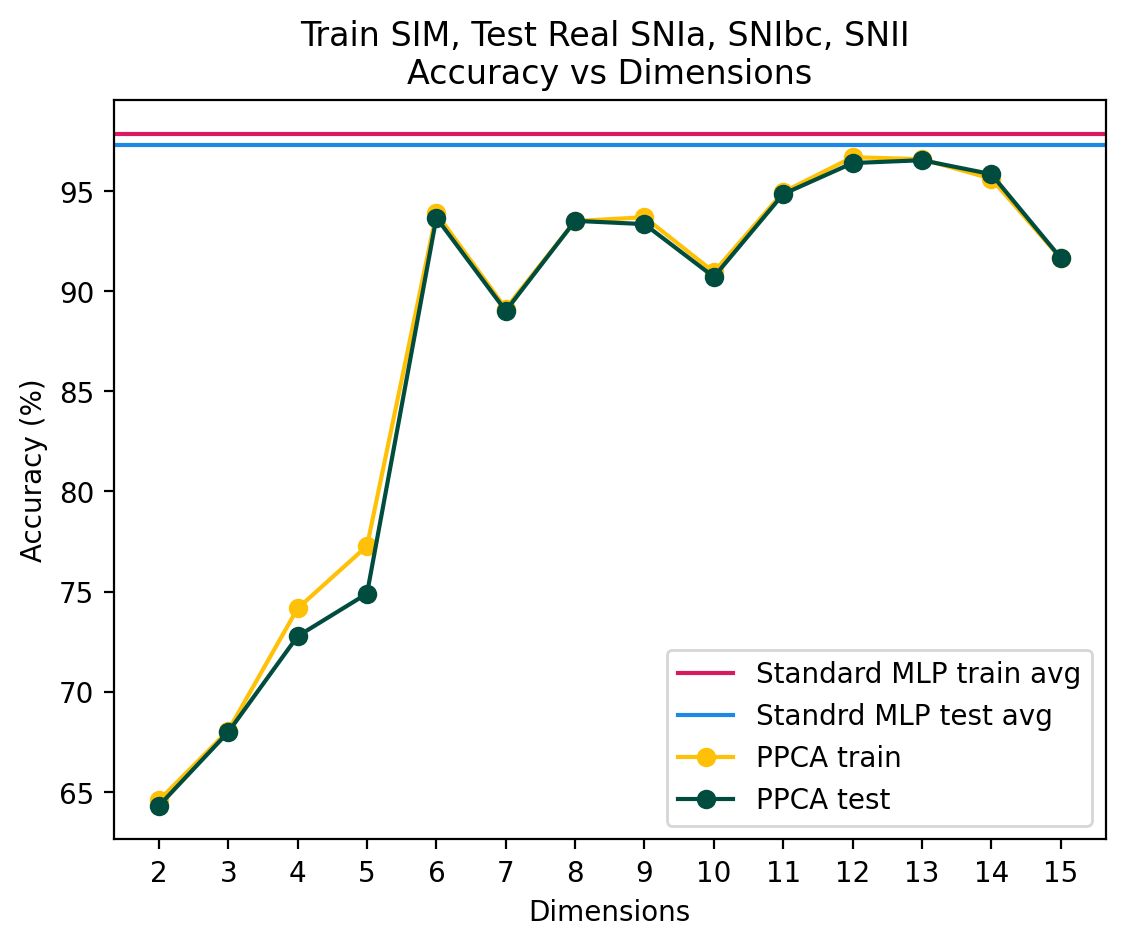

In [15]:
pca_num_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

# The below is from SIM ONLY
# #Used above function to run the mlp clasifier on the "raw" data and then take the mean
# #                   4                   5                    6                    7                    8                    9                10                    11                   12                 13
# raw_train = [0.4759468265346018, 0.5134888570311482, 0.44024762153004043, 0.4048481689039489, 0.4776071940570833, 0.5537599374429819, 0.47154958946956854, 0.5537599374429819, 0.5177062426690995, 0.5230288022937574]
# raw_test = [0.4789662991633435, 0.5098131206505591, 0.44114473375557123, 0.4002658534678239, 0.4766361717100634, 0.5537571350379232, 0.473344280240832, 0.5537571350379232, 0.5173664868246148, 0.5222456798811479]

# #Avg raw_train
# raw_train_avg = sum(raw_train)/len(raw_train)
# raw_test_avg = sum(raw_test)/len(raw_test)

# #Constant so no need to run again
# #                   4                   5                    6                    7                    8                    9                10                    11                   12                 13
# ppca_train = [0.5528476475954646, 0.6044050566922977, 0.7059298840088623, 0.6893001433598331, 0.7132282027890003, 0.7224553629610322, 0.7274859898344845, 0.7658542942786394, 0.753629610321908, 0.7456796559364004]
# ppca_test = [0.5378841191649073, 0.5736961451247166, 0.7004456955195871, 0.6860583313785285, 0.7042771131441082, 0.7150676362499022, 0.7235123934631323, 0.7569786535303776, 0.7432950191570882, 0.7389162561576355]

# #Constant so no need to run again
# #                   4                   5                    6                    7                    8                    9                10                    11                   12                 13
# pca_train = [0.5549068161084322, 0.7460967027238369, 0.7721881923628306, 0.762126938615926, 0.7226899517789652, 0.7349146357356966, 0.7423693470611235, 0.7410139450019549, 0.7500325817802684, 0.749380946174899]
# pca_test = [0.5124716553287982, 0.73406833997967, 0.7561967315661897, 0.7425130971929002, 0.7184299006959105, 0.7285948862303542, 0.7271874266948158, 0.731409805301431, 0.7409492532645242, 0.7487684729064039]

#Make percentage
raw_train_avg =  [x * 100 for x in raw_data_train]
raw_test_avg =  [x * 100 for x in raw_data_test]

raw_train_avg = sum(raw_train_avg)/len(raw_train_avg)
raw_test_avg = sum(raw_test_avg)/len(raw_test_avg)

ppca_train = [x * 100 for x in ppca_data_train]
ppca_test = [x * 100 for x in ppca_data_test]
# pca_train = [x * 100 for x in pca_data_train]
# pca_test = [x * 100 for x in pca_data_test]



# Store raw_train_avg, raw_test_avg, ppca_train, ppca_test, pca_train, pca_test in a csv file
df = pd.DataFrame({'raw_train_avg': raw_train_avg, 'raw_test_avg': raw_test_avg, 'ppca_train': ppca_train, 'ppca_test': ppca_test})
# df.to_csv('Train SIM, Test SIM SNIa, CCSNe.csv')
# df.to_csv('Train SIM, Test Real SNIa, CCSNe.csv')
# df.to_csv('Train SIM, Test Real SNIa, SNIbc, SNII.csv')

# Load Train SIM, Test SIM SNIa, SNII, SNIbc.csv
# df = pd.read_csv('Train SIM, Test SIM SNIa, CCSNe.csv')
# df = pd.read_csv('Train SIM, Test Real SNIa, SNIbc, SNII.csv')
# df = pd.read_csv('Train SIM, Test Real SNIa, CCSNe.csv')
# df = pd.read_csv('Train SIM, Test Real SNIa, SNIbc, SNII.csv')
# print(df)

# Populate raw_train_avg, raw_test_avg, ppca_train, ppca_test, pca_train, pca_test from df
# raw_train_avg = df['raw_train_avg'].to_numpy()
# raw_test_avg = df['raw_test_avg'].to_numpy()
# ppca_train = df['ppca_train'].to_numpy()
# ppca_test = df['ppca_test'].to_numpy()
# pca_train = df['pca_train'].to_numpy()
# pca_test = df['pca_test'].to_numpy()

print(raw_train_avg)


#Plot raw_train_avg and raw_test_avg as a straight line
plt.axhline(y=raw_train_avg, color='#D81B60', linestyle='-', label='Standard MLP train avg')
plt.axhline(y=raw_test_avg, color='#1E88E5', linestyle='-', label='Standrd MLP test avg')

# plot pca_num_list vs raw_train
plt.plot(pca_num_list, ppca_train[0:14], 'o-', color = '#FFC107', label='PPCA train')
plt.plot(pca_num_list, ppca_test[0:14], 'o-', color = '#004D40', label='PPCA test')
# plt.plot(pca_num_list, pca_train, label='pca_train')
# plt.plot(pca_num_list, pca_test, label='pca_test')

plt.xlabel('Dimensions')
plt.ylabel('Accuracy (%)')
plt.title('Train SIM, Test Real SNIa, SNIbc, SNII \nAccuracy vs Dimensions')

plt.xticks(pca_num_list)

plt.legend()

# Save plot with higher resolution
plt.savefig('Train SIM, Test Real SNIa, SNIbc, SNII Accuracy vs Dimensions.png', format='jpg', dpi=800, bbox_inches='tight')
# plt.savefig('Train SIM, Test SIM SNIa, CCSNe Accuracy vs pca_num.pdf')

plt.show()